# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np
import random
import lightgbm as lgb

pd.set_option('display.max_columns', None)

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Maestría en Explotación de Datos/Especialización/2022 - 2C/Data mining en economía y finanzas/Desafíos/Competencia 2/dataset_7110.csv")

Xtrain = df_train[df_train["foto_mes"].isin([202101, 202102, 202103])]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xbajas = df_train.query("foto_mes in (202101, 202102, 202103) and clase_ternaria != 'CONTINUA'")

Y nos deshacemos del target y limpiamos un poco la memoria.

In [5]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [6]:
random.seed(10)

# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


Y miramos su importancia de variables

In [7]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
8,mrentabilidad_annual,167
33,mprestamos_personales,88
10,mactivos_margen,83
72,mcomisiones_mantenimiento,72
203,total_activos,68
...,...,...
152,Visa_cadelantosefectivo,0
35,mprestamos_prendarios,0
150,Visa_mconsumototal,0
53,mpayroll2,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [8]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import shap

In [10]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [11]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cinversion1,minversion1_pesos,minversion1_dolares,cinversion2,minversion2,cseguro_vida,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,cpayroll_trx,mpayroll,mpayroll2,cpayroll2_trx,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,ctarjeta_master_debitos_automaticos,mttarjeta_master_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,ccajeros_propios_descuentos,mcajeros_propios_descuentos,ctarjeta_visa_descuentos,mtarjeta_visa_descuentos,ctarjeta_master_descuentos,mtarjeta_master_descuentos,ccomisiones_mantenimiento,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,cforex,cforex_buy,mforex_buy,cforex_sell,mforex_sell,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,ccajas_transacciones,ccajas_consultas,ccajas_depositos,ccajas_extracciones,ccajas_otras,catm_trx,matm,catm_trx_other,matm_other,ctrx_quarter,tmobile_app,cmobile_app_trx,Master_delinquency,Master_status,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Master_mpagominimo,Visa_delinquency,Visa_status,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,ctrx_quarter_normalizado,mpayroll_sobre_edad,mv_status01,mv_status02,mv_status03,mv_status04,mv_status05,mv_status06,mv_status07,mv_mfinanciacion_limite,mv_Fvencimiento,mv_Finiciomora,mv_msaldototal,mv_msaldopesos,mv_msaldodolares,mv_mconsumospesos,mv_mconsumosdolares,mv_mlimitecompra,mv_madelantopesos,mv_madelantodolares,mv_fultimo_cierre,mv_mpagado,mv_mpagospesos,mv_mpagosdolares,mv_fechaalta,mv_mconsumototal,mv_cconsumos,mv_cadelantosefectivo,mv_mpagominimo,mvr_Master_mlimitecompra,mvr_Visa_mlimitecompra,mvr_msaldototal,mvr_msaldopesos,mvr_msaldopesos2,mvr_msaldodolares,mvr_msaldodolares2,mvr_mconsumospesos,mvr_mconsumosdolares,mvr_madelantopesos,mvr_madelantodolares,mvr_mpagado,mvr_mpagospesos,mvr_mpagosdolares,mvr_mconsumototal,mvr_mpagominimo,vida_banco,mmargen,mmargen_x_producto,total_deuda,total_activos,balance,ratio_deuda,has_cuentacorriente_saldo_pos,has_cajaahorro_saldo_pos,has_saldo_pos,has_internet,has_debito_transacciones,has_visa,has_visa_transacciones,has_master,has_master_transacciones,ctarje

Y consolidamos sus importancias

In [12]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias.head(10)

ctrx_quarter_normalizado        0.894191
mpayroll_sobre_edad             0.390920
cpayroll_trx                    0.309003
total_consumos                  0.251393
total_deuda                     0.195685
mprestamos_personales           0.189127
total_activos                   0.175681
mrentabilidad_annual            0.169904
limite_compra_sobre_ingresos    0.166810
mtarjeta_visa_consumo           0.131742
dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

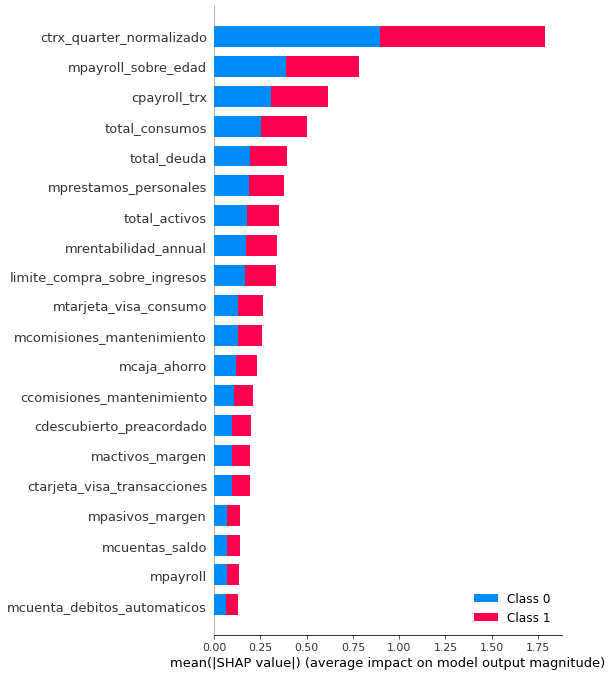

In [13]:
shap.summary_plot(shap_values, Xbajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

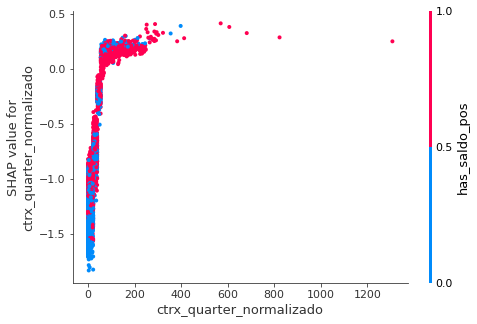

In [14]:
shap.dependence_plot("ctrx_quarter_normalizado", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [15]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [17]:
random.seed(10)

embedding_2d = umap.UMAP(
  n_components=4, n_neighbors=40
).fit_transform(shap_values[0])

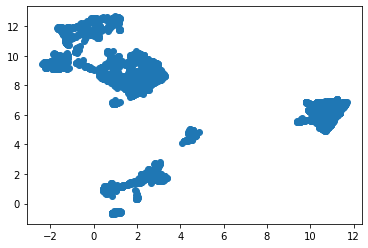

In [18]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [19]:
!pip install hdbscan
#!pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import hdbscan

random.seed(10)

from hdbscan.flat import HDBSCAN_flat
clusterer = HDBSCAN_flat(embedding_2d,
                         cluster_selection_method='eom',
                         n_clusters=3, min_cluster_size=20)
labels = clusterer.labels_

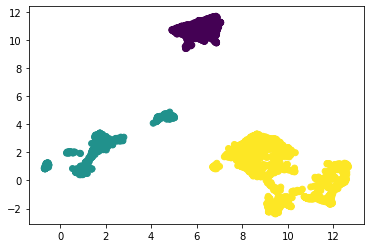

In [21]:
plt.scatter(embedding_2d[:,1], embedding_2d[:,0], c=labels)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [22]:
Xbajas['segmento'] = labels

In [43]:
shap_importancias.head(30)

ctrx_quarter_normalizado        0.894191
mpayroll_sobre_edad             0.390920
cpayroll_trx                    0.309003
total_consumos                  0.251393
total_deuda                     0.195685
mprestamos_personales           0.189127
total_activos                   0.175681
mrentabilidad_annual            0.169904
limite_compra_sobre_ingresos    0.166810
mtarjeta_visa_consumo           0.131742
mcomisiones_mantenimiento       0.128359
mcaja_ahorro                    0.116725
ccomisiones_mantenimiento       0.105325
cdescubierto_preacordado        0.099087
mactivos_margen                 0.098328
ctarjeta_visa_transacciones     0.095909
mpasivos_margen                 0.069542
mcuentas_saldo                  0.069135
mpayroll                        0.067511
mcuenta_debitos_automaticos     0.065213
foto_mes                        0.054909
ccomisiones_otras               0.053448
cproductos                      0.052643
ccaja_seguridad                 0.051662
mv_status01     

In [24]:
import seaborn as sns

Distribución de una variable

In [39]:
def get_variable_distribution(variable):

  print(variable, " (variable importante)" if any(variable in s for s in shap_importancias.head(30).index) else "")

  print("\n")

  display(Xbajas.groupby('segmento')[variable].describe(percentiles = [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))

  print("\n")
  sns.boxplot(x=Xbajas["segmento"], y=Xbajas[variable])
  plt.ylim(np.percentile(Xbajas[variable], 5), np.percentile(Xbajas[variable], 99))
  plt.show()

  #print(Xbajas.groupby('segmento')[variable].describe(percentiles = [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]).to_string())

ctrx_quarter_normalizado  variable importante




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,90.737630,69.512239,3.0,9.35,42.0,47.0,54.0,61.0,72.0,85.0,101.5,126.0,166.0,285.0,1308.0
1,851.0,6.631022,9.347547,0.0,0.00,0.0,0.0,0.0,0.0,3.0,4.0,8.0,12.0,20.0,39.0,51.0
2,2978.0,13.534587,11.451097,0.0,0.00,0.0,2.0,5.0,8.0,12.0,15.0,19.0,25.0,31.0,39.0,39.0


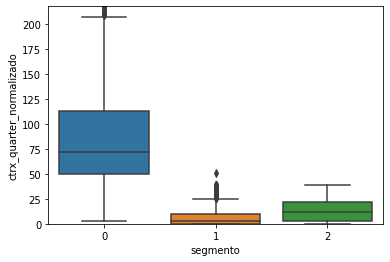

In [37]:
get_variable_distribution("ctrx_quarter_normalizado")

segmentos, principales características

0: cliente más viejos, activos más antiguos, más rentables, ganancia por inversiones/dinero del cliente, con saldo en caja de ahorro (incluso en dolares), usan débito, visa, master, inversiones: usan más plazo fijo, más inversiones, más seguros de vivienda, accidentes personales, perciben salario, débitos automáticos, usan más la app para pagar servicios, más comisiones por otros motivos, reciben más transferencias, envían más transferencias, más extracciones de dinero, usan más la banca telefónica (y el homebanking, y de la app), muchas más transacciones, registran cierta deuda (más x el lado de saldo de las tarjetas), balance bastante positivo. usan más cajeros de otros bancos

1: clientes más nuevos, la mitad sin actividad en el trimestre, algo más jóvenes, mmenos antigüedad, menos rentables, monto cuenta corriente bastante negativo, sin descubierto preacordado, saldo muy negativo, no usan tarjeta débito, no tienen visa, no tienen master, más créditos personales (y hipotecarios), no perciben salario, tarjeta en estado cerrado (más morosidad), límites más chicos, registran cierta deuda (más x el lado de saldos negativos y créditos), balance muy negativo. la mayoría no tiene tarjeta (y el uso es todavía menor). comisiones/producto y comisiones/trx muy alto

2: cuenta corriente en negativo (no tanto como 1), la mayoría tiene descubierto preacordado, saldo negativo la mayoría, pero menos q 1. no usan tarjeta débito, un poquito más de uso de tarjeta que 1, no perciben salario, mayores montos de comisiones de mantenimiento, tarjeta en estado cerrado (más morosidad), límites más chicos, practicamente no endeudados, balance algo positivo. la mayoría tiene tarjetas, pero el uso es considerablemente menor a 0. comisiones/producto y comisiones/trx muy alto

ofrecer maás descuentos, se usan poco.

In [44]:
omitir_cols = ['cliente_vip', 'tcuentas', 'foto_mes', 'ccaja_ahorro', 'mcaja_ahorro_adicional', 'cforex', 'cforex_buy', 'mforex_buy', 'cforex_sell', 'mforex_sell', 'ccheques_depositados', 'mcheques_depositados', 'ccheques_emitidos', 'mcheques_emitidos' \
               'ccheques_depositados_rechazados', 'mcheques_depositados_rechazados', 'ccheques_emitidos_rechazados', 'mcheques_emitidos_rechazados']

for variable in Xbajas.columns[~Xbajas.columns.isin(omitir_cols)]:
  print(variable, " (variable importante)" if any(variable in s for s in shap_importancias.head(30).index) else "")

  print("\n")

  display(Xbajas.groupby('segmento')[variable].describe(percentiles = [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))

  print("\n")

numero_de_cliente 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9.963355e+07,4.156962e+07,31127916.0,32756243.00,40861092.5,63306576.0,75469348.0,83332219.0,95505137.5,110834167.0,122413453.5,137820004.0,154976174.0,1.960704e+08,210415097.0
1,851.0,1.180417e+08,4.278629e+07,31282207.0,34331851.00,60607249.0,76957452.0,88822660.0,107395331.0,120189269.0,134776692.0,148059530.0,159772254.0,174336838.0,1.951384e+08,209785317.0
2,2978.0,1.108953e+08,4.633308e+07,31229316.0,32633024.97,43891615.9,67163524.0,80418134.2,92652333.0,107753632.0,123164814.2,139062236.4,154862369.8,177006785.3,2.051152e+08,212170051.0




active_quarter 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.561692,0.496471,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2978.0,0.769644,0.421131,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




internet 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.063151,0.289754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,851.0,0.249119,0.481648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
2,2978.0,0.122565,0.375726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0




cliente_edad 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,48.500651,13.731060,20.0,25.0,31.0,35.0,39.0,43.0,47.0,52.0,56.0,62.0,67.0,79.65,88.0
1,851.0,46.638073,13.684965,19.0,23.5,30.0,35.0,38.0,41.0,44.0,48.0,53.0,59.0,66.0,79.50,88.0
2,2978.0,49.173271,14.202677,21.0,24.0,31.0,36.0,40.0,43.0,48.0,52.0,57.0,63.0,69.0,81.00,93.0




cliente_antiguedad 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,127.460286,81.363917,1.0,8.0,34.0,55.0,70.0,90.0,115.5,140.0,165.0,193.0,236.0,322.0,375.0
1,851.0,97.775558,72.255219,5.0,14.0,32.0,41.0,48.0,57.0,69.0,90.0,124.0,156.0,199.0,321.0,374.0
2,2978.0,104.559436,83.531987,1.0,6.0,17.0,33.0,44.0,59.0,77.0,110.0,137.9,174.6,231.0,322.0,375.0




mrentabilidad  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1890.886719,5198.878239,-25374.53,-5930.680,-1133.945,-52.500,231.345,607.830,1190.170,1649.10,2070.815,2749.610,4624.960,23382.4380,70015.54
1,851.0,1096.545417,5341.748624,-34343.51,-17328.245,-681.720,-2.020,20.860,297.240,1230.590,1517.48,1811.960,2297.390,3510.290,16860.1250,85517.62
2,2978.0,1731.315470,5679.417687,-29113.33,-3811.443,0.000,133.248,518.841,1259.828,1481.595,1718.82,1953.306,2353.324,3027.342,10863.3756,160117.54




mrentabilidad_annual  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,16059.062988,45651.551912,-96147.95,-41220.9000,-7615.485,-184.240,2865.345,5441.330,8037.905,11214.070,16235.345,24884.530,43143.345,153341.3205,772601.07
1,851.0,14412.887086,34362.496992,-103230.51,-47033.4100,-6132.080,433.040,2545.670,5688.350,9308.360,13016.930,17056.390,22828.420,37228.700,150159.6300,482765.63
2,2978.0,12084.234389,30527.905030,-192280.71,-22401.5347,0.000,1761.396,3679.814,5465.502,7423.330,10353.444,14625.045,19457.436,25916.261,75359.8190,816480.24




mcomisiones  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1478.550345,2570.919477,-13432.52,-570.8085,39.545,159.570,323.280,637.40,1224.295,1592.20,1844.335,2249.080,2871.000,10364.3180,49309.58
1,851.0,733.977509,1441.970652,-15682.01,-1477.7850,0.000,0.000,0.000,0.00,88.540,1225.04,1240.580,1592.200,1764.200,3105.4400,19145.58
2,2978.0,1184.710934,1289.538880,-12175.36,-1073.7037,0.000,52.668,273.784,1225.04,1270.040,1592.20,1676.170,1814.528,2267.974,3435.2526,30177.57




mactivos_margen  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-448.565098,3001.247517,-22551.41,-8258.8880,-2662.715,-1403.650,-728.530,-334.550,-138.580,-22.350,0.275,79.230,685.120,9441.4475,43736.84
1,851.0,109.946052,3294.261414,-29662.35,-14772.5900,-669.640,-97.220,0.000,0.000,22.600,121.320,299.570,610.640,1932.190,9756.5850,19880.00
2,2978.0,340.004752,4653.096736,-39907.34,-3767.3368,-346.146,-75.066,-3.072,2.284,21.505,75.234,154.809,320.464,808.705,6080.3873,134010.69




mpasivos_margen  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,800.086699,2651.974671,-3655.73,-555.3935,13.995,57.95,113.535,192.390,279.815,394.050,592.610,865.160,1501.935,8740.7900,56835.10
1,851.0,199.148402,2813.946611,-374.84,0.0000,0.000,0.00,0.060,0.750,3.220,8.730,22.790,58.630,162.060,1698.0200,72856.90
2,2978.0,125.983203,705.102378,-6742.26,-382.5806,0.000,0.00,0.243,3.948,12.560,31.036,62.182,126.258,283.505,2115.5933,24988.47




cproductos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,6.850260,1.341291,3.0,4.0,5.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,10.0,14.0
1,851.0,5.186839,1.223925,3.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,7.0,9.0,11.0
2,2978.0,6.316655,1.200212,4.0,4.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,9.0,11.0




ccuenta_corriente 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2978.0,1.000672,0.025911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0




mcuenta_corriente_adicional 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,851.0,-44.682620,1303.477127,-38024.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,2978.0,4.425504,241.504404,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13179.15




mcuenta_corriente 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-13.849499,37254.317515,-969864.61,-28490.8895,-4536.335,-1493.610,-480.200,-175.680,-25.340,0.000,0.000,0.0,0.0,42107.7020,663743.51
1,851.0,-29185.106275,127844.103771,-1372480.76,-706827.1200,-33249.670,-16049.770,-9904.420,-4645.870,-1207.020,-325.120,-59.630,0.0,0.0,533.9200,11917.21
2,2978.0,-6583.042471,21785.581349,-861465.73,-62919.4611,-18917.275,-8315.494,-4331.103,-2154.282,-801.855,-246.356,-44.782,0.0,0.0,1247.7359,115097.50




mcaja_ahorro  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,35540.654967,159780.831539,0.0,0.0,0.0,268.99,1515.035,3437.95,6310.635,10568.820,17601.195,32488.670,64853.325,420823.2430,3989708.85
1,851.0,6355.453584,100525.297492,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.890,47.070,299.910,2203.640,35417.0100,2752487.19
2,2978.0,5387.052488,44002.026136,0.0,0.0,0.0,0.00,0.000,0.00,1.950,117.494,735.208,2354.644,8937.797,69062.0609,1915038.84




mcaja_ahorro_dolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,28193.867233,258104.697189,-1130.77,0.0,0.0,0.0,0.0,0.0,0.0,9.71,102.5,3758.36,29215.750,499637.0075,7984516.08
1,851.0,5888.517438,162338.462466,-8.63,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,38.830,4248.2450,4734429.08
2,2978.0,18972.021884,309310.653127,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13.70,529.562,248687.3624,14306348.63




cdescubierto_preacordado  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.901042,0.298703,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.090482,0.287039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.993284,0.081689,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




mcuentas_saldo  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,59485.221914,351284.149429,-907864.11,-33490.7735,-4617.680,-1756.69,0.000,475.46,3213.995,10464.460,25602.815,52302.080,115747.310,760195.9600,9773714.32
1,851.0,-19845.052597,210877.756119,-1347146.44,-706810.6100,-34281.390,-17543.51,-10610.390,-5223.46,-2200.320,-1483.370,0.080,88.850,1499.510,81462.4450,3808293.81
2,2978.0,15975.356659,317894.883231,-867893.84,-69795.9507,-19698.289,-9640.98,-5179.515,-2979.14,-1729.785,-154.612,59.188,1672.838,13018.644,351145.7742,14392871.70




ctarjeta_debito 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.475260,0.790440,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,7.0
1,851.0,1.296122,0.571250,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0
2,2978.0,1.473136,0.730898,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,7.0




ctarjeta_debito_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4.527344,7.818330,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,8.0,14.0,35.0,77.0
1,851.0,0.096357,0.706357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
2,2978.0,0.198120,0.925347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,21.0




mautoservicio  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9252.438288,18681.127960,0.0,0.0,0.0,0.0,0.0,0.0,1153.095,3418.21,7571.565,13794.06,26923.795,90651.5060,215080.02
1,851.0,328.899835,3192.455243,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.000,10679.1150,56574.30
2,2978.0,443.684997,3314.514657,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.000,10199.5936,113176.84




ctarjeta_visa  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.858724,0.352139,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
1,851.0,0.249119,0.435467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
2,2978.0,0.795165,0.411071,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0




ctarjeta_visa_transacciones  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9.325521,12.763936,0.0,0.0,0.0,0.0,1.0,3.0,5.0,8.0,11.0,16.0,25.0,55.65,153.0
1,851.0,0.372503,1.704981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.50,20.0
2,2978.0,1.527535,3.537041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,16.23,63.0




mtarjeta_visa_consumo  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,19911.689980,34726.481485,0.0,0.0,0.0,0.0,704.85,3872.17,8630.845,13838.23,19875.225,30435.320,54516.315,157713.7090,455312.33
1,851.0,737.629459,5209.753221,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,0.000,0.000,16846.1300,124786.81
2,2978.0,3238.577834,9813.662469,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,736.290,3172.856,9612.995,44044.9126,152492.14




ctarjeta_master 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.785156,0.410848,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.235018,0.427023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
2,2978.0,0.699127,0.458715,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




ctarjeta_master_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.610677,5.302030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,25.65,81.0
1,851.0,0.092832,1.133275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,31.0
2,2978.0,0.139019,1.033605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.23,32.0




mtarjeta_master_consumo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4069.546217,15569.065451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0,9592.115,70615.6340,355325.45
1,851.0,194.558002,1867.482047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5476.6150,36934.16
2,2978.0,365.839715,3082.539731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,9226.7983,108718.14




cprestamos_personales 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.438151,5.293111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,147.0
1,851.0,1.081081,4.380627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,23.5,57.0
2,2978.0,0.067495,0.454675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0




mprestamos_personales  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9191.671504,64619.898117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,229258.0085,1372139.34
1,851.0,24563.997180,89916.203285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3755.27,51663.54,472352.2500,912170.08
2,2978.0,448.221138,2550.720601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,15538.7242,28917.54




cprestamos_prendarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000651,0.025516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,851.0,0.022327,0.400846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,2978.0,0.016454,0.197561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0




mprestamos_prendarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,92.888704,3640.478859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142677.05
1,851.0,341.644031,5949.118457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133483.83
2,2978.0,2114.548606,36694.656195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1193353.13




cprestamos_hipotecarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.008464,0.141858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,851.0,0.047004,0.686097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2,2978.0,0.003694,0.075477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0




mprestamos_hipotecarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,10888.573867,209872.103823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4921362.77
1,851.0,8763.904982,176525.319437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3702154.83
2,2978.0,173.905215,4719.333811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164626.67




cplazo_fijo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.145182,1.384094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,44.0
1,851.0,0.005875,0.076471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.015447,0.126035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




mplazo_fijo_dolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,37197.037227,266385.703478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1152472.50,5494332.00
1,851.0,11944.819506,322198.670123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,9384000.00
2,2978.0,4525.985292,61991.234391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113687.16,2271369.04




mplazo_fijo_pesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9334.794421,316158.970552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12308825.61
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,2978.0,182.203462,9943.035076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,542601.91




cinversion1 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.020182,0.170025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
1,851.0,0.003525,0.059304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.007388,0.100113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0




minversion1_pesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2241.495026,56791.308844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16884.11,2193329.94
1,851.0,3.497485,72.108821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1507.93
2,2978.0,540.067055,13102.920455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,471242.21




minversion1_dolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,851.0,121.848649,3554.557116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103693.2
2,2978.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




cinversion2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.082031,1.414597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,38.0
1,851.0,0.004700,0.068438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.016454,0.179756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0




minversion2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1714.037643,32598.764165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1398.5855,1005463.37
1,851.0,431.530306,8687.664342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,181385.84
2,2978.0,246.149177,8083.467442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.4593,313942.18




cseguro_vida 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050130,0.218285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,851.0,0.028202,0.165647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.041639,0.201470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




cseguro_auto 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.016927,0.179685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1,851.0,0.011751,0.160450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,2978.0,0.011753,0.113852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




cseguro_vivienda 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.114583,0.324698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
1,851.0,0.030552,0.172202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.057085,0.241966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




cseguro_accidentes_personales 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.126953,0.334979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
1,851.0,0.051704,0.221559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.083613,0.276853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ccaja_seguridad  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.022135,0.151534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,851.0,0.004700,0.068438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.013768,0.116545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




cpayroll_trx  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.309245,0.884948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,18.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mpayroll  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,22550.933047,134560.516188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54657.725,323300.019,3523523.08
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.00
2,2978.0,2.717831,128.621565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,6920.70




mpayroll2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,60.1125,1592.704063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52949.33
1,851.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,2978.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00




cpayroll2_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.001953,0.044165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




ccuenta_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.696615,1.653468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,35.0
1,851.0,0.050529,0.253974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,2978.0,0.123237,0.411365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0




mcuenta_debitos_automaticos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2089.652292,11623.988169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.49,1439.02,5290.36,27678.278,290826.17
1,851.0,32.816475,383.143829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,494.900,9055.56
2,2978.0,142.291880,1332.330903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3556.530,39658.66




ctarjeta_visa_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.923828,2.797869,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,5.0,13.0,20.0
1,851.0,0.106933,0.543701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0
2,2978.0,0.466420,1.067607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,8.0




mttarjeta_visa_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4315.505137,9164.187725,0.0,0.0,0.0,0.0,0.0,0.0,532.77,1852.17,4211.645,6439.77,12237.260,38249.0405,140694.65
1,851.0,196.805335,1552.860128,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,6850.1550,31048.66
2,2978.0,830.458143,2965.261209,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,492.03,2113.773,13270.1089,53377.57




ctarjeta_master_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.291016,1.197423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.00,13.0
1,851.0,0.022327,0.234083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,4.0
2,2978.0,0.042982,0.344104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.23,9.0




mttarjeta_master_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,650.213333,3321.655318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.71,16524.2440,62418.08
1,851.0,48.169741,645.170684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,608.1950,15348.00
2,2978.0,75.837199,959.869027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1571.8315,30820.65




cpagodeservicios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.023438,0.475563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.000672,0.025911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




mpagodeservicios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,96.498171,1809.326654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47360.74
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,2978.0,7.750856,307.120013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14241.68




cpagomiscuentas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.607422,3.279020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,16.0,39.0
1,851.0,0.025852,0.327973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
2,2978.0,0.076226,0.467160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0




mpagomiscuentas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,8900.300078,45837.015873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2082.1,7821.63,20445.415,117076.6655,1074363.35
1,851.0,63.504042,844.273317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,469.2000,20907.68
2,2978.0,208.193670,2254.890096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,5388.0437,87997.94




ccajeros_propios_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.045573,0.289681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,851.0,0.001175,0.034280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.000336,0.018325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




mcajeros_propios_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,10.099388,159.892468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.9665,5622.48
1,851.0,0.137838,4.020992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,117.30
2,2978.0,0.395698,21.593682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1178.39




ctarjeta_visa_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050130,0.303229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
1,851.0,0.001175,0.034280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.008395,0.117055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0




mtarjeta_visa_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1519.0,21.706228,240.075978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,375.1846,5213.16
1,851.0,0.247967,7.233672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,211.02
2,2971.0,4.830623,125.760232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,5027.94




ctarjeta_master_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.027344,0.271144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,851.0,0.001175,0.034280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.001679,0.040948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




mtarjeta_master_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1521.0,1.188409,21.160347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,588.17
1,850.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,2974.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00




ccomisiones_mantenimiento  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.582682,0.624943,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0
1,851.0,0.558167,0.645227,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0
2,2978.0,0.735729,0.585635,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,7.0




mcomisiones_mantenimiento  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,932.539668,1110.936123,-7878.47,0.00,0.0,0.0,0.0,0.00,0.00,1364.94,1774.04,1774.04,2505.95,3413.33,4469.03
1,851.0,738.797227,998.932293,-4094.84,-1928.17,0.0,0.0,0.0,0.00,0.00,1364.94,1364.94,1774.04,1928.17,2626.15,3413.33
2,2978.0,1144.314137,1043.483630,-6824.74,-1364.94,0.0,0.0,0.0,1364.94,1364.94,1622.81,1774.04,1928.17,2505.95,3413.33,4229.34




ccomisiones_otras  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,7.398438,4.181248,0.0,0.0,2.0,4.0,4.0,6.0,6.0,8.0,8.0,10.0,12.0,21.0,52.0
1,851.0,1.992949,2.258567,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,6.0,10.0,13.0
2,2978.0,3.488247,2.701229,0.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,4.0,6.0,6.0,12.0,27.0




mcomisiones_otras 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1479.109915,2571.008034,-13432.52,-570.8085,39.545,161.210,323.280,637.40,1224.295,1592.20,1844.335,2249.080,2871.000,10364.3180,49309.58
1,851.0,733.970435,1441.974902,-15682.01,-1477.7850,0.000,0.000,0.000,0.00,88.540,1225.04,1240.580,1592.200,1764.200,3105.4400,19145.58
2,2978.0,1184.889553,1289.688877,-12175.36,-1073.7037,0.000,52.668,273.784,1225.04,1269.520,1592.20,1676.170,1819.348,2272.574,3435.2526,30177.57




ctransferencias_recibidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2.707031,9.402618,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,13.0,260.0
1,851.0,0.274971,1.043556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,15.0
2,2978.0,0.458697,1.122258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,20.0




mtransferencias_recibidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,63933.617904,265586.852738,0.0,0.0,0.0,0.0,791.775,7272.6,17008.5,29442.3,47109.435,74602.8,124357.955,596653.9425,6038470.92
1,851.0,2322.438414,12394.714084,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,3358.290,51060.2750,187918.72
2,2978.0,8697.224553,75871.791336,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,3519.0,11730.000,117300.0000,1963277.91




ctransferencias_emitidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2.006510,3.846733,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,6.0,15.0,67.0
1,851.0,0.056404,0.393016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,6.0
2,2978.0,0.145064,0.586871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0




mtransferencias_emitidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,46355.263757,230022.582172,0.0,0.0,0.0,0.0,0.0,0.0,381.5,4966.99,14076.0,32515.56,78542.47,812576.1595,4420853.06
1,851.0,2265.771786,51097.473308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,15542.2500,1480795.20
2,2978.0,3248.692095,54160.422044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,45166.2107,2521954.44




cextraccion_autoservicio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.585938,3.327377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,15.65,30.0
1,851.0,0.088132,0.701587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,13.0
2,2978.0,0.100403,0.602029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,11.0




mextraccion_autoservicio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,13950.241400,35070.710038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5865.0,17595.0,43225.05,177064.35,414069.0
1,851.0,696.494595,5681.460912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,29325.00,82110.0
2,2978.0,837.509453,6467.533365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23729.79,199761.9




mcheques_emitidos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2599.135905,44140.148578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19310.5125,1467657.60
1,851.0,13.645946,398.078229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,11612.70
2,2978.0,68.293193,2757.387742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,141372.35




ccheques_depositados_rechazados 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.001302,0.036073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




tcallcenter  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.160156,0.366870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,851.0,0.078731,0.269477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.099396,0.299243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ccallcenter_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.960938,4.119680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,17.0,86.0
1,851.0,0.336075,1.572515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.5,18.0
2,2978.0,0.421088,1.759466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,28.0




thomebanking  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.769531,0.421270,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.262045,0.440005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2978.0,0.467092,0.499000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0




chomebanking_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,45.500651,67.349765,0.0,0.0,0.0,2.0,6.0,12.0,21.0,35.0,53.0,75.0,116.0,320.85,800.0
1,851.0,4.622797,14.509953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,75.50,150.0
2,2978.0,10.625252,21.450303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,18.0,37.0,101.00,228.0




ccajas_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.115885,0.320192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,851.0,0.182139,0.386186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2978.0,0.054735,0.227500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ccajas_consultas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.166667,0.849347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,16.0
1,851.0,0.519389,1.825451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.00,18.0
2,2978.0,0.121222,0.775688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.23,18.0




ccajas_depositos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.052083,0.324698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,851.0,0.034078,0.200035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,2978.0,0.011753,0.119607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




ccajas_extracciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.057943,0.303983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1,851.0,0.007051,0.083720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.015782,0.155795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0




ccajas_otras 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.057292,0.348994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0
1,851.0,0.263220,1.044334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,18.0
2,2978.0,0.021155,0.190175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0




catm_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.097656,2.784245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,12.65,30.0
1,851.0,0.058754,0.568861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,11.0
2,2978.0,0.074882,0.525565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,11.0




matm 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,11231.784473,32807.257192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11143.5,35190.0,163809.45,402339.0
1,851.0,567.478378,5239.880677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18768.00,82110.0
2,2978.0,707.841353,6301.309970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23460.00,199761.9




catm_trx_other 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.488281,1.606134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,28.0
1,851.0,0.029377,0.295586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
2,2978.0,0.025520,0.293280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0




matm_other 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2718.456927,11027.689299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8211.0,42228.000,228735.0
1,851.0,129.016216,1422.827071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3401.700,30498.0
2,2978.0,129.668099,1509.384378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2480.895,35190.0




ctrx_quarter  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,90.600911,69.579914,3.0,8.0,41.5,47.0,53.0,61.0,72.0,85.0,101.5,126.0,165.5,285.0,1308.0
1,851.0,6.631022,9.347547,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,8.0,12.0,20.0,39.0,51.0
2,2978.0,13.523842,11.449335,0.0,0.0,0.0,2.0,5.0,8.0,12.0,15.0,19.0,25.0,31.0,39.0,39.0




tmobile_app 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050781,0.219622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,851.0,0.004700,0.068438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.015782,0.124654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




cmobile_app_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.688802,0.463134,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.200940,0.400939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2978.0,0.329752,0.470202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




Master_delinquency 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,0.007981,0.089014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,248.0,0.052419,0.223322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2194.0,0.013218,0.114233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




Master_status 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,0.334397,1.696380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
1,248.0,1.729839,3.505288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,9.0
2,2194.0,0.442115,1.914157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0




Master_mfinanciacion_limite 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,298132.456640,402782.318948,0.0,25336.8,63342.00,76010.4,88678.8,126684.0,177357.6,202694.4,253368.0,493630.3,709430.400,1.399943e+06,4323273.29
1,248.0,182460.604758,205622.859057,0.0,0.0,48773.34,63342.0,63342.0,88678.8,101347.2,126684.0,177357.6,253368.0,490579.077,9.311629e+05,1335242.75
2,2194.0,245653.489695,349223.658144,0.0,25336.8,50673.60,63342.0,88678.8,101347.2,126684.0,177357.6,253368.0,304041.6,520717.700,1.414285e+06,3705662.82




Master_Fvencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,-988.499601,541.123412,-2221.0,-2190.00,-1643.0,-1507.8,-1340.0,-1184.0,-882.0,-670.0,-578.0,-486.0,-364.0,-105.56,-60.0
1,248.0,-1041.487903,581.319544,-2221.0,-2204.84,-1838.9,-1460.0,-1370.0,-1248.0,-1108.0,-820.8,-639.0,-486.0,-243.7,-58.94,122.0
2,2194.0,-1068.871923,587.769417,-2221.0,-2190.00,-1854.4,-1580.0,-1460.0,-1309.0,-1123.5,-760.0,-637.0,-517.0,-336.0,-88.00,3989.0




Master_Finiciomora 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,10.0,43.200000,44.802778,13.0,13.27,15.7,16.0,18.8,20.0,21.5,23.0,31.4,63.2,114.6,135.66,138.0
1,13.0,63.384615,48.146544,6.0,7.20,16.0,17.6,24.2,46.2,53.0,79.4,83.0,100.4,110.0,161.92,169.0
2,29.0,55.896552,49.651172,9.0,9.00,19.2,20.0,21.2,30.8,41.0,50.4,51.0,77.8,144.2,169.00,169.0




Master_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,7896.417965,35279.817828,-12982.84,-356.6500,0.0,0.0,0.0,0.0,0.0,0.0,296.444,4038.456,21766.794,106251.7176,766890.02
1,248.0,10231.942258,57205.102767,-848.51,-90.1505,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,7532.167,326304.5922,613615.67
2,2194.0,1307.195096,14866.870615,-77415.30,-330.1035,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,133.943,29609.3605,603541.48




Master_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,7864.650128,35176.328061,-12982.84,-323.1932,0.0,0.0,0.0,0.0,0.0,0.0,321.296,4013.486,21798.064,105866.5336,766890.02
1,248.0,10231.942258,57205.102767,-848.51,-90.1505,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,7532.167,326304.5922,613615.67
2,2194.0,1326.046591,14735.465661,-15263.63,-274.6741,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,149.785,29084.7305,603541.48




Master_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,31.767741,778.158168,-18255.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1237.23,11179.05
1,248.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2,2194.0,-18.851513,1971.411753,-84684.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,31066.41




Master_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,9563.154876,22787.104061,-880.98,0.0,0.0,0.0,0.0,727.448,1990.72,3992.46,7755.108,13093.942,29601.574,85131.8976,355207.21
1,54.0,2570.866296,8821.556757,0.00,0.0,0.0,0.0,0.0,0.000,0.00,0.00,52.198,1364.194,4196.143,42857.6644,55059.07
2,284.0,1988.550106,5764.470066,-765.73,0.0,0.0,0.0,0.0,0.000,0.00,0.00,517.462,1388.830,5367.692,30884.5649,43622.28




Master_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,1.720989,10.712272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.9340,120.37
1,54.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00
2,284.0,3.384296,35.631029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.9658,483.13




Master_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,332007.486209,447682.970476,12316.50,28152.000,70380.0,84456.0,98532.0,140760.0,197064.0,225216.0,281520.0,548557.67,788256.000,1.555492e+06,4803636.99
1,248.0,204609.601774,227359.139735,5700.78,9624.465,56304.0,70380.0,70380.0,98532.0,112608.0,140760.0,197064.0,281520.00,545166.926,1.034625e+06,1483603.06
2,2194.0,273065.198851,387843.548960,5700.78,28152.000,56304.0,70380.0,98532.0,112608.0,140760.0,197064.0,281520.0,337824.00,578659.140,1.571430e+06,4117403.13




Master_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,34.267416,433.426338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7038.0
1,54.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,284.0,43.367958,530.396621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7624.5




Master_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




Master_fultimo_cierre 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,2.728651,6.088127,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,11.0,25.0,25.0
1,248.0,2.762097,6.022550,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,11.0,25.0,25.0
2,2194.0,2.420237,5.392845,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,7.0,21.0,25.0




Master_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,1429.471804,11942.015419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40581.3304,293250.00
1,248.0,248.047742,3145.482978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2964.9759,49230.81
2,2194.0,386.640137,12984.373918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1361.4914,603541.48




Master_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,-13688.121775,21543.998608,-163665.94,-107488.9912,-34470.816,-21764.030,-13320.484,-8835.576,-5675.030,-3205.008,-1601.278,-619.91,-33.344,0.0000,199.43
1,54.0,-4996.852963,11606.528329,-75860.18,-51320.8726,-11173.152,-7781.682,-3695.337,-1642.200,-388.965,-0.328,0.000,0.00,0.000,444.3744,848.51
2,284.0,-5231.239894,12370.137667,-132208.43,-51646.8531,-11812.110,-7507.048,-4432.403,-2270.472,-1173.000,-528.240,-200.776,0.00,0.000,0.0000,1042.69




Master_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,4.301618,56.893767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.2864,1171.17
1,54.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00
2,284.0,1.084085,16.752691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3565,281.74




Master_fechaalta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,2367.504389,1819.267401,6.0,56.12,368.2,544.0,1051.0,1590.8,2006.0,2489.4,3173.0,3904.0,4981.2,7543.00,7587.0
1,248.0,1839.875000,1575.883975,103.0,163.15,425.1,563.0,722.6,1041.6,1303.5,1662.6,2026.1,3023.6,4543.1,6437.43,7215.0
2,2194.0,1917.659070,1696.822835,2.0,71.93,272.3,419.6,606.9,998.6,1406.0,1853.0,2548.4,3385.2,4525.5,7524.00,7602.0




Master_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,9563.154876,22787.104061,-880.98,0.0,0.0,0.0,0.0,727.448,1990.72,3992.46,7755.108,13093.942,29601.574,85131.8976,355207.21
1,54.0,2570.866296,8821.556757,0.00,0.0,0.0,0.0,0.0,0.000,0.00,0.00,52.198,1364.194,4196.143,42857.6644,55059.07
2,284.0,1988.550106,5764.470066,-765.73,0.0,0.0,0.0,0.0,0.000,0.00,0.00,517.462,1388.830,5367.692,30884.5649,43622.28




Master_cconsumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,3.568539,5.703476,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.8,6.0,10.0,23.56,60.0
1,54.0,1.074074,4.653470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.7,18.10,34.0
2,284.0,0.855634,2.483216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,7.00,35.0




Master_cadelantosefectivo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,0.015730,0.195039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,54.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,284.0,0.024648,0.319161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0




Master_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,1922.961716,22747.704962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.17,2263.890,22441.3668,766883.94
1,248.0,4755.994718,27503.515143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1537.803,178317.3486,231045.81
2,2194.0,683.531800,10208.758387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,9247.8147,414714.15




Visa_delinquency 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,0.021199,0.144099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,263.0,0.087452,0.283036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2483.0,0.026581,0.160887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




Visa_status 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,0.332602,1.692461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
1,263.0,1.707224,3.434477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.6,9.0,9.0,9.0
2,2483.0,0.432541,1.894418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0




Visa_mfinanciacion_limite 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,298837.602939,363960.518382,505.56,25336.8,63342.00,88678.8,101347.2,126684.0,177357.6,202694.4,253368.0,481176.33,703564.995,1399942.650,3481876.80
1,263.0,176998.100114,183329.666971,0.00,0.0,39272.04,63342.0,63342.0,88678.8,101347.2,177357.6,202694.4,253368.00,354715.200,830951.008,1335242.75
2,2483.0,238234.419299,289293.233176,0.00,25336.8,63342.00,76010.4,101347.2,126684.0,177357.6,177357.6,253368.0,253368.00,506736.000,1399942.650,3512896.64




Visa_Fvencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,-5529.474415,111338.289355,-2914178.0,-2190.00,-1916.0,-1766.0,-1643.0,-1521.0,-1309.0,-1156.0,-943.0,-788.0,-548.0,-110.77,366.0
1,263.0,-1308.444867,680.786335,-2220.0,-2200.64,-2039.0,-1856.0,-1746.2,-1613.0,-1521.0,-1339.0,-1020.8,-698.0,-249.6,98.92,2617.0
2,2483.0,-7200.163512,130608.505796,-2914237.0,-2218.00,-2006.0,-1884.0,-1763.0,-1641.0,-1460.0,-1245.0,-1020.8,-760.0,-456.0,-60.00,307.0




Visa_Finiciomora 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,29.0,16.137931,22.384185,0.0,0.0,0.0,0.0,0.0,2.8,17.0,17.0,20.2,24.0,28.0,94.52,113.0
1,23.0,47.000000,40.408145,0.0,0.0,2.8,21.0,21.0,26.6,49.0,49.6,54.8,72.8,86.6,157.46,170.0
2,66.0,32.757576,37.966812,0.0,0.0,0.0,0.0,17.0,21.0,21.0,21.0,33.0,52.0,75.0,170.00,170.0




Visa_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,24292.806857,39760.641751,-63993.57,-296.0438,0.0,843.688,3451.721,7320.934,11744.945,16344.902,23591.781,35966.302,60595.615,205027.0856,400980.16
1,263.0,12185.384030,55615.346557,-46587.27,-1447.0422,0.0,0.000,0.000,0.000,0.000,174.038,1515.600,6072.166,21447.258,354285.6706,495899.95
2,2483.0,5585.311611,31903.859485,-119926.06,-3790.6786,0.0,0.000,0.000,0.000,0.000,612.420,2227.370,5480.786,12845.888,78252.3282,1157351.65




Visa_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,28153.756469,46224.121897,-84667.10,-344.1116,0.0,989.64,4128.15,8466.544,13787.76,19057.558,27552.427,41791.508,70342.256,230342.4827,470349.72
1,263.0,14491.201635,65099.938912,-8063.06,-733.8476,0.0,0.00,0.00,0.000,0.00,356.878,1898.484,7122.642,24870.168,415577.0852,581690.64
2,2483.0,6623.939513,37326.987923,-140673.26,-3247.3646,0.0,0.00,0.00,0.000,0.00,712.352,2640.994,6451.370,15117.592,93743.9826,1357573.48




Visa_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,342.654978,3223.442516,-15104.69,-1277.9908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9212.0040,67547.62
1,263.0,-197.747985,3498.503346,-56570.35,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.3566,4084.70
2,2483.0,-72.371261,2451.591287,-77159.22,-48.9384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,314.9298,35844.02




Visa_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,17124.357540,31208.741615,-7082.48,-3.1200,0.0,902.628,2479.406,4915.658,7313.10,10944.700,16901.85,25025.872,44845.640,125374.1138,450300.75
1,130.0,2605.983615,10226.124459,-1255.69,-79.4916,0.0,0.000,0.000,0.000,69.81,505.906,736.93,1766.634,6507.688,28225.4913,107402.12
2,1296.0,4278.773264,10612.012725,-4451.33,-6.6605,0.0,0.000,0.000,469.200,817.21,1549.150,3138.22,5814.910,11203.225,42175.6260,128039.98




Visa_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,7.703188,58.052930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.81,6.174,169.6864,1113.39
1,130.0,1.031154,5.701820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,31.7593,45.61
2,1296.0,0.773395,11.136443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,13.2285,385.95




Visa_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,332084.717632,404422.684589,1011.71,28152.00,70380.0,98532.0,112608.0,140760.0,197064.0,225216.0,281520.0,534717.91,781755.016,1.555492e+06,3868752.00
1,263.0,199928.132890,201657.338078,6158.25,23295.78,50673.6,70380.0,70380.0,98532.0,112608.0,197064.0,225216.0,281520.00,394128.000,9.232937e+05,1483603.06
2,2483.0,264791.101973,321332.615229,3519.00,28152.00,70380.0,84456.0,112608.0,140760.0,197064.0,197064.0,281520.0,281520.00,563040.000,1.555492e+06,3903218.49




Visa_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,3.926360,135.729438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4692.0
1,130.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1296.0,4.525463,162.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5865.0




Visa_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




Visa_fultimo_cierre 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,3.387427,6.325056,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,7.0,11.0,25.0,35.0
1,263.0,3.266160,6.713712,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,7.0,11.0,25.0,25.0
2,2483.0,3.334273,6.378049,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,11.0,25.0,39.0




Visa_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,3460.759956,13406.154217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8732.315,63552.3091,207034.50
1,263.0,892.282890,4835.176821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,24351.4800,54167.43
2,2483.0,1470.030439,27822.268923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,23597.6874,1357573.48




Visa_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,-28939.384636,40206.684055,-406322.64,-192592.3378,-66508.242,-42275.968,-30483.586,-23160.184,-16656.60,-11749.046,-7930.814,-4493.694,-1333.948,0.0000,24901.08
1,130.0,-6179.365923,12392.548360,-90057.82,-61669.7472,-15647.820,-8953.008,-6770.965,-5468.520,-2609.20,-849.058,-340.660,0.000,0.000,2511.1118,35190.00
2,1296.0,-9077.694066,16680.165521,-273125.16,-72883.9085,-23027.380,-13163.870,-9047.775,-5926.450,-4080.86,-2134.130,-1183.110,-496.460,0.000,0.0000,38826.35




Visa_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,5.569431,55.384345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.1796,1278.72
1,130.0,0.186692,2.125087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0284,24.23
2,1296.0,0.797137,14.131868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.4425,460.93




Visa_fechaalta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,3119.173977,2132.742857,13.0,114.03,527.8,1192.8,1684.2,2094.4,2732.0,3534.2,4220.9,4974.8,5759.1,9156.23,10314.0
1,263.0,2190.186312,1802.566904,103.0,251.48,535.8,810.8,1087.2,1248.4,1462.0,1827.6,2623.8,3643.6,4981.4,8328.52,9277.0
2,2483.0,2564.165526,2108.189389,4.0,117.82,368.0,635.4,1111.0,1441.4,1880.0,2612.6,3507.0,4479.2,5607.0,8650.90,10520.0




Visa_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,17124.357540,31208.741615,-7082.48,-3.1200,0.0,902.628,2479.406,4915.658,7313.10,10944.700,16901.85,25025.872,44845.640,125374.1138,450300.75
1,130.0,2605.983615,10226.124459,-1255.69,-79.4916,0.0,0.000,0.000,0.000,69.81,505.906,736.93,1766.634,6507.688,28225.4913,107402.12
2,1296.0,4278.773264,10612.012725,-4451.33,-6.6605,0.0,0.000,0.000,469.200,817.21,1549.150,3138.22,5814.910,11203.225,42175.6260,128039.98




Visa_cconsumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,7.772385,8.913322,0.0,0.0,0.0,1.0,2.0,4.0,5.0,6.0,9.0,13.0,19.0,41.06,68.0
1,130.0,1.353846,2.332319,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,7.71,18.0
2,1296.0,2.064815,2.451783,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,11.00,16.0




Visa_cadelantosefectivo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,0.001674,0.057856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,130.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1296.0,0.000772,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




Visa_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,5324.348999,15633.776866,0.0,0.0,0.0,0.0,222.87,645.15,1173.0,1923.72,3120.180,5438.028,13382.757,74379.2262,262388.37
1,263.0,8074.164867,43567.010939,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,150.144,1001.742,6707.214,298244.1648,375195.78
2,2483.0,2194.417032,25393.600376,0.0,0.0,0.0,0.0,0.00,0.00,0.0,23.46,199.410,703.800,1982.370,28141.9122,954470.10




ctrx_quarter_normalizado  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,90.737630,69.512239,3.0,9.35,42.0,47.0,54.0,61.0,72.0,85.0,101.5,126.0,166.0,285.0,1308.0
1,851.0,6.631022,9.347547,0.0,0.00,0.0,0.0,0.0,0.0,3.0,4.0,8.0,12.0,20.0,39.0,51.0
2,2978.0,13.534587,11.451097,0.0,0.00,0.0,2.0,5.0,8.0,12.0,15.0,19.0,25.0,31.0,39.0,39.0




mpayroll_sobre_edad  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,528.909345,3116.804681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1313.905514,7087.813648,74968.57617
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000
2,2978.0,0.040394,1.918196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,103.29403




mv_status01  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,0.358790,1.752807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
1,307.0,1.785016,3.507141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8,9.0,9.0,9.0
2,2585.0,0.483559,1.986560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0




mv_status02 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1233.0,0.655312,3.309827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0
1,204.0,3.509804,6.862111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,18.0,18.0,18.0
2,2092.0,0.818356,3.640398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0




mv_status03 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2.253906,4.145951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0,10.0
1,851.0,8.056404,3.881978,0.0,0.0,0.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,2978.0,3.283412,4.654860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0,10.0,10.0




mv_status04 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,3.505208,6.835716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,18.0,20.0,20.0
1,851.0,15.027027,7.854888,0.0,0.0,0.0,10.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
2,2978.0,4.981195,7.582332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,20.0,20.0,20.0




mv_status05 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,141.112630,344.226292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1000.0,1010.0,1010.0
1,851.0,751.303173,431.235205,0.0,0.0,0.0,10.0,909.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0
2,2978.0,205.241773,398.726491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,900.0,1010.0,1010.0,1010.0




mv_status06 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.268880,3.277795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0
1,851.0,7.031727,4.472944,0.0,0.0,0.0,0.0,7.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,2978.0,1.726326,3.707384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0




mv_status07 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.270182,3.280470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0
1,851.0,6.975323,4.516959,0.0,0.0,0.0,0.0,7.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,2978.0,1.710880,3.698317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0




mv_mfinanciacion_limite 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,509355.344395,707012.976572,0.0,0.0,6629.205,114015.6,152020.8,202694.4,253368.0,354715.2,506736.0,760104.0,1222730.455,3.140577e+06,6963753.60
1,851.0,107873.948660,249639.476100,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,69676.2,158355.0,354715.200,1.213092e+06,2670485.50
2,2978.0,379617.132139,565928.180950,0.0,0.0,0.000,76010.4,126684.0,164689.2,202694.4,266036.4,354715.2,506736.0,962798.400,2.671135e+06,7025793.28




mv_Fvencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,-5550.984870,110530.532870,-2914178.0,-2190.0,-1978.0,-1797.0,-1674.0,-1582.0,-1429.0,-1245.0,-1063.3,-879.0,-639.0,-208.97,152.0
1,307.0,-1357.416938,598.225613,-2221.0,-2218.0,-2070.0,-1878.4,-1735.0,-1611.8,-1519.0,-1339.0,-1094.8,-790.0,-472.4,-61.68,1005.0
2,2585.0,-7037.214313,128006.805367,-2914237.0,-2218.0,-2069.0,-1916.0,-1794.0,-1672.0,-1549.0,-1339.0,-1122.0,-879.0,-608.0,-88.00,3989.0




mv_Finiciomora 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,34.0,20.058824,29.348420,0.0,0.0,0.0,0.0,0.0,16.0,17.0,18.6,21.2,24.0,28.0,129.75,138.0
1,29.0,45.689655,39.839054,0.0,0.0,4.8,16.0,21.0,21.0,28.0,50.6,56.6,79.8,90.8,152.48,169.0
2,82.0,30.182927,30.600221,0.0,0.0,0.0,9.0,17.0,20.0,21.0,21.0,36.1,50.6,54.7,147.94,169.0




mv_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,28077.325189,55433.637533,-63993.57,-211.2065,0.0,0.0,1626.26,5523.39,11229.94,17123.300,25052.160,41209.980,73053.250,245186.7655,856332.87
1,851.0,6747.682350,53997.158439,-28702.74,-309.0800,0.0,0.0,0.00,0.00,0.00,0.000,0.000,0.000,2027.950,121300.2400,905999.21
2,2978.0,5619.984812,39846.416290,-119926.06,-3803.4421,0.0,0.0,0.00,0.00,0.00,171.546,1444.394,4813.554,12367.502,80951.3016,1760893.13




mv_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,31490.068659,60655.979025,-84667.10,-247.7395,0.0,0.0,1898.54,6277.34,12975.42,19734.95,28259.700,45624.77,82003.705,274881.8775,892289.59
1,851.0,7460.291081,58732.444449,-8063.06,-185.9000,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,2496.130,133849.5600,991230.28
2,2978.0,6499.861662,44738.102069,-140673.26,-3174.2497,0.0,0.0,0.00,0.00,0.00,220.67,1653.464,5591.27,14447.802,94531.5354,1961114.96




mv_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,331.091790,3146.664983,-18255.32,-1340.0510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9336.2125,67547.62
1,851.0,-61.113655,1944.482923,-56570.35,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4084.70
2,2978.0,-74.230376,2805.986588,-84684.05,-19.5787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0353,35844.02




mv_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,16093.236445,34343.638758,-7082.48,0.0,0.0,0.0,277.17,1900.26,5031.915,8663.64,14642.015,24114.210,45310.510,128154.9170,696007.60
1,851.0,561.227556,4710.577334,-1255.69,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,0.000,0.000,13527.0750,107402.12
2,2978.0,2051.725447,7697.545871,-4451.33,0.0,0.0,0.0,0.00,0.00,0.000,0.00,232.063,1253.408,5614.767,30888.6196,128039.98




mv_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,6.491634,51.779302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.75,121.9135,1113.39
1,851.0,0.157521,2.252057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,45.61
2,2978.0,0.659322,13.293483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,6.0066,483.13




mv_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,566599.787721,785556.351567,0.0,0.0,14076.0,126684.0,168912.0,225216.0,281520.0,394128.0,563040.0,844560.0,1358700.945,3.489530e+06,7737504.00
1,851.0,121415.135358,277535.931929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84456.0,182988.0,394128.000,1.348042e+06,2967206.12
2,2978.0,421954.785923,628629.450608,0.0,0.0,0.0,84456.0,140760.0,182988.0,225216.0,295596.0,394128.0,563040.0,1069776.000,2.967928e+06,7806436.98




mv_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,12.982422,262.396436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7038.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,6.105272,196.060535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7624.5




mv_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,851.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mv_fultimo_cierre 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,4.468300,7.174697,-3.0,-3.0,-3.0,-3.0,1.0,1.0,4.0,4.0,4.0,7.0,18.0,25.0,35.0
1,307.0,3.899023,7.091344,-3.0,-3.0,-3.0,-3.0,1.0,1.0,4.0,4.0,4.0,7.0,15.6,25.0,25.0
2,2585.0,3.870793,6.781955,-3.0,-3.0,-3.0,-3.0,1.0,1.0,4.0,4.0,4.0,7.0,11.0,25.0,39.0




mv_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4248.338405,17821.467092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10527.935,67601.8960,306270.30
1,851.0,348.044935,3218.348725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,9948.8150,54167.43
2,2978.0,1510.535272,36330.848701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,22267.9808,1961114.96




mv_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-26480.324759,43357.848146,-494027.00,-190689.1620,-66948.965,-40363.020,-27969.775,-18961.430,-12226.125,-6671.06,-2552.035,0.0,0.0,0.0,24901.08
1,851.0,-1261.043043,6635.967538,-99367.38,-26112.1900,-741.350,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.0,0.0,35190.00
2,2978.0,-4449.416938,13438.189749,-273125.16,-54158.4705,-12860.878,-5404.172,-1628.150,-77.102,0.000,0.00,0.000,0.0,0.0,0.0,38826.35




mv_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,5.579225,57.807270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.159,1278.72
1,851.0,0.028519,0.830593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,24.23
2,2978.0,0.450292,10.669728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.160,460.93




mv_fechaalta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,3182.231268,2122.838787,13.0,115.83,545.0,1297.2,1752.1,2185.6,2807.5,3627.0,4267.8,5017.6,5858.0,9150.03,10314.0
1,307.0,2183.224756,1776.108141,103.0,292.86,495.2,804.0,1079.0,1264.4,1515.0,1841.0,2601.8,3623.8,4988.6,8135.88,9277.0
2,2585.0,2585.115667,2101.866713,4.0,118.84,376.8,657.8,1124.2,1459.6,1926.0,2632.0,3524.8,4520.2,5622.8,8643.28,10520.0




mv_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,16093.236445,34343.638758,-7082.48,0.0,0.0,0.0,277.17,1900.26,5031.915,8663.64,14642.015,24114.210,45310.510,128154.9170,696007.60
1,851.0,561.227556,4710.577334,-1255.69,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,0.000,0.000,13527.0750,107402.12
2,2978.0,2051.725447,7697.545871,-4451.33,0.0,0.0,0.0,0.00,0.00,0.000,0.00,232.063,1253.408,5614.767,30888.6196,128039.98




mv_cconsumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,7.080729,9.804605,0.0,0.0,0.0,0.0,1.0,2.0,4.0,6.0,8.0,12.0,19.0,42.3,127.0
1,851.0,0.274971,1.587324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,34.0
2,2978.0,0.980188,2.087427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,9.0,35.0




mv_cadelantosefectivo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.005859,0.116818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.002686,0.100350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0




mv_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,6310.664362,26205.925295,0.0,0.0,0.0,0.0,64.515,492.66,1090.89,1923.72,3155.37,5712.510,14498.28,82770.9855,766883.94
1,851.0,3881.306757,36275.184037,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.00,0.00,0.000,199.41,76942.9350,588623.13
2,2978.0,2333.245890,30570.194588,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.00,117.30,546.618,1853.34,26264.7603,1369184.25




mvr_Master_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,0.481688,0.108601,0.111111,0.200000,0.368421,0.416667,0.466667,0.5,0.5,0.5,0.5,0.500000,0.503081,1.0,1.0
1,248.0,0.580242,0.216612,0.048186,0.165622,0.395385,0.466667,0.500000,0.5,0.5,0.5,0.5,0.736842,1.000000,1.0,1.0
2,2194.0,0.501539,0.138166,0.049505,0.238095,0.368421,0.416667,0.500000,0.5,0.5,0.5,0.5,0.500000,0.566674,1.0,1.0




mvr_Visa_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,0.573425,0.163541,0.011837,0.263158,0.5,0.5,0.5,0.5,0.5,0.500000,0.569841,0.625000,0.879167,1.0,1.0
1,263.0,0.620152,0.223943,0.157895,0.263158,0.5,0.5,0.5,0.5,0.5,0.538462,0.615385,1.000000,1.000000,1.0,1.0
2,2483.0,0.597916,0.190755,0.047619,0.263158,0.5,0.5,0.5,0.5,0.5,0.533333,0.583333,0.666667,1.000000,1.0,1.0




mvr_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.123691,0.715072,-0.063939,-0.000944,0.0,0.0,0.004471,0.012068,0.026064,0.044565,0.069200,0.117916,0.226005,0.875145,16.949684
1,851.0,0.023982,0.164936,-0.254891,-0.002440,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008005,0.754725,3.183322
2,2978.0,0.020815,0.136007,-0.608564,-0.015061,0.0,0.0,0.000000,0.000000,0.000000,0.000338,0.003917,0.014957,0.042029,0.289121,4.623374




mvr_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.140403,0.836107,-0.075000,-0.001446,0.0,0.0,0.004998,0.013864,0.029748,0.051488,0.079573,0.134981,0.259007,0.966410,19.881974
1,851.0,0.026855,0.181030,-0.045136,-0.001801,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009049,0.805858,3.562665
2,2978.0,0.023900,0.156314,-0.713846,-0.014387,0.0,0.0,0.000000,0.000000,0.000000,0.000407,0.004687,0.017271,0.048685,0.338050,5.423218




mvr_msaldopesos2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.912433,0.518405,0.000000,0.0,0.0,0.0,1.066321,1.126524,1.16901,1.172998,1.172999,1.173000,1.173000,1.226451,5.801258
1,851.0,0.200509,0.433939,-0.690109,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.172853,1.173000,1.175861
2,2978.0,0.531026,0.622427,-11.549252,0.0,0.0,0.0,0.000000,0.000000,0.00000,1.089374,1.172991,1.172999,1.173000,1.175537,3.574267




mvr_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000977,0.011069,-0.129691,-0.002579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036063,0.258979
1,851.0,-0.000571,0.017229,-0.502365,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014509
2,2978.0,-0.000083,0.006024,-0.241384,-0.000063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000692,0.115748




mvr_msaldodolares2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-0.002803,0.195447,-4.628258,-0.049168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298459,0.676391
1,851.0,0.002733,0.068029,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.970904
2,2978.0,0.013883,0.269680,-2.401267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501164,12.722258




mvr_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.045560,0.092963,-0.050316,0.0,0.0,0.0,0.000635,0.004616,0.010868,0.021246,0.037685,0.062807,0.124282,0.461378,1.133704
1,851.0,0.001866,0.012149,-0.000715,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057032,0.231964
2,2978.0,0.007308,0.029379,-0.004311,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000479,0.003689,0.017230,0.123293,0.572244




mvr_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.976441e-05,0.000169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.000429,0.004084
1,851.0,7.247472e-07,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000289
2,2978.0,2.475089e-06,0.000059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000019,0.002860




mvr_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000067,0.001514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2978.0,0.000017,0.000560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023551




mvr_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,851.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mvr_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.011652,0.055736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01962,0.206852,1.459406
1,851.0,0.001550,0.016220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.055134,0.384821
2,2978.0,0.003313,0.026782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.075425,0.782462




mvr_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-0.101304,0.557798,-13.564359,-0.699513,-0.211098,-0.116410,-0.074535,-0.050230,-0.030071,-0.014962,-0.005686,0.0,0.0,0.0,0.063180
1,851.0,-0.007621,0.045186,-0.898221,-0.176527,-0.002153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.178571
2,2978.0,-0.016197,0.052544,-1.213333,-0.214472,-0.045000,-0.016077,-0.004595,-0.000205,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.043099




mvr_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.312516e-05,0.000150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000375,0.004911
1,851.0,1.012023e-07,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000086
2,2978.0,1.090741e-06,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.001668




mvr_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.045560,0.092963,-0.050316,0.0,0.0,0.0,0.000635,0.004616,0.010868,0.021246,0.037685,0.062807,0.124282,0.461378,1.133704
1,851.0,0.001866,0.012149,-0.000715,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057032,0.231964
2,2978.0,0.007308,0.029379,-0.004311,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000479,0.003689,0.017230,0.123293,0.572244




mvr_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.063673,0.795430,0.0,0.0,0.0,0.0,0.000196,0.000997,0.002343,0.005,0.008977,0.017292,0.037208,0.326163,19.388840
1,851.0,0.014356,0.144060,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000833,0.264769,3.562583
2,2978.0,0.009062,0.115688,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000288,0.001692,0.006564,0.140180,4.739792




vida_banco 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.218806,0.122690,0.002252,0.013880,0.061471,0.100000,0.136291,0.174679,0.205518,0.245098,0.292425,0.330952,0.384067,0.514400,0.594444
1,851.0,0.178343,0.118321,0.008013,0.021505,0.051768,0.076797,0.095238,0.111111,0.142857,0.178922,0.229885,0.282051,0.359756,0.515224,0.556818
2,2978.0,0.177169,0.127999,0.002381,0.010256,0.031250,0.055556,0.081202,0.108211,0.146994,0.189011,0.247467,0.302083,0.366162,0.487971,0.612745




mmargen 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,351.521602,3888.439878,-21749.18,-6912.3215,-2014.190,-864.620,-261.960,-35.91,55.75,153.150,372.810,775.150,2150.385,14606.5725,57378.46
1,851.0,309.094454,4332.823727,-29278.36,-14772.5900,-556.400,-57.500,1.530,17.97,62.11,184.890,355.230,715.970,2186.140,10907.7500,72845.11
2,2978.0,465.987955,4669.376338,-27247.81,-3635.0719,-262.349,-7.052,9.472,38.79,85.76,146.384,246.798,458.626,953.918,6743.8794,133890.95




mmargen_x_producto 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,51.098563,536.618635,-4349.836000,-1001.274313,-295.917857,-124.104286,-38.566310,-5.130000,8.365143,23.773333,57.342738,117.998333,320.466250,1986.795933,7079.854286
1,851.0,47.712878,777.356153,-5069.570000,-2936.297083,-101.537500,-14.375000,0.314000,3.816000,12.577500,37.565714,64.176000,130.596667,408.800000,2181.550000,12140.851667
2,2978.0,89.161444,845.759082,-4541.301667,-573.502497,-39.783800,-1.052944,1.508964,6.015257,14.042500,23.240667,38.476000,76.631400,179.833333,1421.321205,26778.190000




total_deuda  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,48250.459264,227436.028524,-63993.57,-196.1875,0.0,0.0,3273.02,7661.17,13160.3,20006.22,29252.210,49515.700,91168.195,481803.4865,4923146.38
1,851.0,40417.228543,204594.557654,-28702.74,-151.4900,0.0,0.0,0.00,0.00,0.0,0.00,556.120,19596.320,68390.080,573892.0400,3715122.97
2,2978.0,8356.659772,54184.316810,-119926.06,-3803.4421,0.0,0.0,0.00,0.00,0.0,592.59,2529.725,6609.544,15630.867,140216.6975,1760893.13




total_activos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,109972.586230,638635.664235,-907864.11,-33490.7735,-4347.460,-1635.220,2.780,835.100,4643.27,13468.690,33359.265,69818.090,166129.015,1.640160e+06,16273509.69
1,851.0,-7343.356651,412706.145307,-1347146.44,-706810.6100,-34281.390,-17426.600,-10595.650,-5215.110,-2198.07,-1470.060,0.120,103.950,1654.530,1.363003e+05,10349986.66
2,2978.0,21469.761645,325055.936281,-845568.00,-69795.9507,-19580.727,-9542.214,-5144.239,-2913.466,-1681.98,-89.416,78.006,1949.698,15917.740,5.147689e+05,14392871.70




balance  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,61722.126966,679857.700561,-4931176.09,-490352.8715,-75352.040,-36054.40,-19438.520,-9687.210,-2018.955,1122.070,16386.930,47295.340,146298.825,1.612671e+06,16174325.51
1,851.0,-47760.585194,462144.672515,-3714733.27,-935014.8800,-133367.990,-48607.41,-24520.680,-14770.550,-9178.500,-3497.730,-1648.120,0.890,258.490,1.230086e+05,10349986.66
2,2978.0,13113.101874,329375.636349,-1789516.74,-198796.6444,-29679.024,-17140.77,-10878.821,-7228.732,-4309.820,-2157.592,-383.169,349.732,12557.816,5.138328e+05,14392871.70




ratio_deuda 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,811.805388,11891.951099,-128527.285714,-558.644584,-10.883896,-0.644621,0.0,0.0,0.0644,0.267752,0.833738,3.043347,23.683921,15450.334482,336686.007194
1,851.0,827.575534,19141.946296,-68008.941296,-120.575490,-7.190175,-0.027523,0.0,0.0,0.0000,0.000000,0.000000,0.000000,1.302466,3873.618806,534168.410000
2,2978.0,131.636867,2042.098400,-14918.860000,-110.815500,-2.721777,-0.267318,0.0,0.0,0.0000,0.000000,0.000000,0.057451,2.280153,1835.582746,69467.910000




has_cuentacorriente_saldo_pos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.069661,0.254659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,851.0,0.035253,0.184526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.028878,0.167493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




has_cajaahorro_saldo_pos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.898438,0.302170,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.439483,0.496616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2978.0,0.520484,0.499664,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




has_saldo_pos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.772786,0.419168,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.329025,0.470135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2,2978.0,0.389859,0.487800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




has_internet 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050781,0.219622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,851.0,0.226792,0.419003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2978.0,0.105776,0.307602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0




has_debito_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.550130,0.497643,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.034078,0.181535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.082942,0.275840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




has_visa 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.857422,0.349756,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.247944,0.432073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2978.0,0.792142,0.405843,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




has_visa_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.725260,0.446528,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.092832,0.290367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.356951,0.479181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




has_master 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.785156,0.410848,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.233843,0.423522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,2978.0,0.699127,0.458715,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




has_master_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.236328,0.424964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,851.0,0.027027,0.162258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.053056,0.224182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ctarjetas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.643880,0.700024,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
1,851.0,0.484136,0.795972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0
2,2978.0,1.494291,0.778965,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0




cseguros 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.308594,0.587451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0
1,851.0,0.122209,0.380851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0
2,2978.0,0.194090,0.468639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0




has_payroll 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.190755,0.393024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2978.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mpayroll_total 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,22611.045547,134586.485489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54798.93,323300.019,3523523.08
1,851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00
2,2978.0,2.717831,128.621565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,6920.70




has_da 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.710938,0.453475,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.108108,0.310700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2978.0,0.321692,0.467204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




has_pmc 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.386068,0.487005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.011751,0.107826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2978.0,0.035930,0.186147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




debitos_automaticos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,7055.370762,17127.859685,0.0,0.0,0.0,0.0,70.2,919.53,2393.39,4340.41,6563.275,10692.99,17605.865,58876.3650,399126.03
1,851.0,277.791551,1755.494350,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.00,69.810,7833.8450,31048.66
2,2978.0,1048.587223,3379.582604,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,70.490,750.57,3283.050,15594.2911,53377.57




total_consumos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,40385.543418,54680.729805,0.0,0.0,1241.88,5293.45,11532.98,17994.21,25428.97,32428.890,43926.510,63408.150,93601.460,226230.3865,720335.38
1,851.0,1538.878848,7230.430458,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,1996.100,34130.7550,124786.81
2,2978.0,5104.440625,12868.220307,0.0,0.0,0.00,0.00,0.00,0.00,0.00,667.022,2618.722,6603.878,15119.627,56965.3662,152492.14




total_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,32.742181,287.294934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,752.328,5622.48
1,851.0,0.385805,8.271998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,211.02
2,2978.0,5.214966,127.440081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5027.94




total_descuentos_sobre_consumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.001242,0.018203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024644,0.636668
1,851.0,0.000054,0.001388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040000
2,2978.0,0.000428,0.008445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.249999




has_comisiones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.981120,0.136146,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,851.0,0.613396,0.487258,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2978.0,0.883143,0.321304,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




total_comisiones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2411.649583,3227.544305,-14643.32,-680.0820,38.53,167.690,339.930,713.99,1881.595,2865.180,3554.335,4046.500,5271.39,11882.818,51815.53
1,851.0,1472.767662,2182.430878,-13753.84,-3658.7000,0.00,0.000,0.000,0.00,192.400,2589.980,2602.610,3366.240,3658.70,5510.620,21073.75
2,2978.0,2329.203690,2147.948324,-12605.21,-2535.4521,0.00,60.816,295.473,2589.98,2624.730,3101.262,3394.677,3668.992,4755.03,6623.393,30177.57




balance_transferencias 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,17578.354147,242891.942120,-3459844.66,-546145.219,-16713.225,0.0,0.0,0.0,5865.0,15952.8,29834.735,48903.84,88481.740,354577.565,5974542.42
1,851.0,56.666627,51957.810280,-1480795.20,-366.130,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,2564.080,44131.190,187918.72
2,2978.0,5448.532458,87506.690311,-2521954.44,-28963.716,0.000,0.0,0.0,0.0,0.0,0.0,0.000,2346.00,10543.165,81382.740,1963277.91




cajeros_ajenos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.113932,0.317832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,851.0,0.008226,0.090375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2978.0,0.012760,0.112257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ctrx_x_producto 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,13.525892,9.596420,0.428571,1.195833,5.714286,6.666667,8.00,9.142857,10.875000,12.666667,15.535714,19.333333,25.242857,46.5575,130.80
1,851.0,1.200316,1.661358,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.500000,0.833333,1.500000,2.200000,3.571429,7.0000,9.75
2,2978.0,2.113490,1.811972,0.000000,0.000000,0.000000,0.250000,0.75,1.285714,1.833333,2.333333,3.000000,3.714286,4.750000,6.5000,9.75




comisiones_x_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,35.658985,62.410469,-387.85125,-10.811821,0.486757,1.984878,3.977945,7.867444,17.461933,32.059455,47.841296,61.47125,83.118292,270.542136,930.335
1,851.0,496.100743,1047.962822,-4403.71000,-470.532407,0.000000,0.000000,0.000000,0.000000,33.784444,143.839630,281.438462,615.85400,2377.515000,4755.030000,6476.790
2,2978.0,586.122848,1207.009651,-10976.14000,-173.475496,0.000000,2.750083,16.906911,104.544853,152.351765,217.026222,339.226382,663.15500,2589.980000,4807.490700,9028.710




master_vencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,-3.168396,1.484604,-7.0,-6.00,-5.0,-5.0,-4.0,-4.0,-3.0,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0
1,248.0,-3.298387,1.563655,-7.0,-6.53,-5.3,-4.0,-4.0,-4.0,-3.5,-3.0,-2.0,-2.0,-1.0,-1.0,0.0
2,2194.0,-3.374658,1.607670,-7.0,-6.00,-6.0,-5.0,-4.0,-4.0,-4.0,-3.0,-2.0,-2.0,-1.0,-1.0,10.0




master_alta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,5.983240,4.979723,0.0,0.0,1.0,1.0,2.0,4.0,5.0,6.0,8.0,10.0,13.0,20.0,20.0
1,248.0,4.560484,4.304735,0.0,0.0,1.0,1.0,1.1,2.0,3.0,4.0,5.0,7.6,12.0,17.0,19.0
2,2194.0,4.766636,4.647664,0.0,0.0,0.0,1.0,1.0,2.0,3.0,5.0,6.0,9.0,12.0,20.0,20.0




visa_vencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,-15.614766,305.055101,-7985.0,-6.00,-6.0,-5.0,-5.0,-5.0,-4.0,-4.0,-3.0,-3.0,-2.0,-1.0,1.0
1,263.0,-4.041825,1.882564,-7.0,-6.38,-6.0,-6.0,-5.0,-5.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,7.0
2,2483.0,-20.179621,357.850930,-7985.0,-7.00,-6.0,-6.0,-5.0,-5.0,-4.0,-4.0,-3.0,-3.0,-2.0,-1.0,0.0




visa_alta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,8.037281,5.845430,0.0,0.0,1.0,3.0,4.0,5.0,7.0,9.0,11.0,13.0,15.0,25.00,28.0
1,263.0,5.528517,4.922893,0.0,0.0,1.0,2.0,2.0,3.0,4.0,5.0,7.0,9.6,13.0,22.38,25.0
2,2483.0,6.533629,5.771360,0.0,0.0,1.0,1.0,3.0,3.0,5.0,7.0,9.0,12.0,15.0,23.00,28.0




limite_compra_promedio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,286837.954956,406737.880972,0.0,0.0,0.0,63342.0,84456.0,112608.0,140760.0,197064.0,281520.0,422280.0,681531.940,1849774.08,3868752.00
1,851.0,60154.429683,151171.075516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84456.0,197064.000,788256.00,1483603.06
2,2978.0,217919.011281,324114.251390,0.0,0.0,0.0,49266.0,70380.0,98532.0,119646.0,168912.0,211140.0,281520.0,542260.578,1555491.84,3903218.49




pagado_sobre_saldo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.137437,0.365610,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.716025,1.177202,3.475376
1,851.0,0.025160,0.182722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.172998,2.919643
2,2978.0,1.491879,77.644876,-167.198925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.189680,4233.000000




consumo_promedio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1728.343646,6195.236195,-1045.610,0.0,0.0,0.0,163.8875,648.779565,1017.014696,1386.485,1827.993056,2496.17,3632.74875,10850.3840,225150.375000
1,851.0,158.524378,974.658676,-627.845,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000,0.000000,0.00,0.00000,3676.3500,16325.605000
2,2978.0,631.408787,2162.870167,-2225.665,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000,169.752250,709.82,1796.39800,8189.7114,41654.196667




limite_compra_sobre_ingresos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,295.0,11218.593501,150689.656212,0.0,0.000000,0.000000,0.594966,1.940540,3.029319,4.253425,7.171747,11.473845,23.324121,135.290880,112244.493115,2.559273e+06
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,28.474576,40.269132,0.0,0.569492,5.694915,11.389831,17.084746,22.779661,28.474576,34.169492,39.864407,45.559322,51.254237,56.379661,5.694915e+01




limite_compra_sobre_activos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1514.0,-1624.369466,1.382531e+05,-4.379200e+06,-8809.274700,-168.342989,-26.920813,0.000000,0.714168,3.879794,8.703834,24.332254,74.941577,409.947653,47340.388911,1.735039e+06
1,830.0,-1409.398414,5.224023e+04,-1.012698e+06,-1258.650415,-64.387334,-11.299471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12605.052632,4.331077e+05
2,2887.0,-30302.909044,4.189393e+06,-2.149878e+08,-14362.402889,-247.736966,-107.281198,-49.524272,-19.590462,-5.021213,0.000000,3.640208,50.005919,657.087700,84912.982118,4.504320e+07




limite_compra_real_sobre_esperado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1514.0,-480012.793067,920859.686837,-7737504.00,-3.110984e+06,-1255414.621,-788256.0,-478584.0,-365976.0,-253368.0,-197064.0,-140760.0,-70380.0,0.0,808307.775275,1.073454e+07
1,830.0,-121098.821651,274658.682089,-2967206.12,-1.232984e+06,-394128.000,-182988.0,-84456.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00
2,2887.0,-418052.157150,632195.911352,-7806436.98,-3.101945e+06,-1069776.000,-563040.0,-394128.0,-281520.0,-225216.0,-168912.0,-140760.0,-84456.0,0.0,0.000000,4.510003e+03




na_count 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,18.764323,18.773165,0.0,3.0,4.0,4.0,12.0,13.0,13.0,13.0,15.0,24.0,40.0,71.0,73.0
1,851.0,53.649824,24.234677,1.0,2.0,13.0,24.0,40.0,71.0,71.0,71.0,71.0,71.0,71.0,73.0,73.0
2,2978.0,27.133983,19.302739,1.0,4.0,13.0,13.0,13.0,22.0,24.0,24.0,26.0,40.0,71.0,71.0,73.0




segmento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,851.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2978.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
